# Phase 1: Business Understanding

## Four business questions regarding the data

### 1. Is there high or low variance between the mean price per bedroom/bathroom and observed list prices (entire units only)?
### 2. As the number of bedrooms increase does list price increase? What about number of bathrooms (entire units only)?
### 3. Can we provide Airbnb owners typical rental prices in different Boston neighborhoods?
### 4. Can we provide Boston Airbnb owners feedback on rental type demand (IE, are rooms/shared rooms/full units in higher demand)?

# Phase 2: Data Understanding 

In [ ]:
#import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import ALookAtTheData as t
from IPython import display
%matplotlib inline
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

#read csv files from Kaggle for Boston listings
#https://www.kaggle.com/airbnb/boston?select=listings.csv
#NOTE: file renamed from listings.csv to boston_listings.csv
df_b_list = pd.read_csv('boston_listings.csv')
################################
#show all column names and data types
df_b_list.dtypes.to_dict()

In [ ]:
#check columns of interest for business questions
df_b_list[['price','bedrooms', 'bathrooms','room_type','neighbourhood_cleansed','calendar_updated', 'availability_90']]

In [2]:
#price is of type object and used for multiple data frames; need to change to float before creating seperate data frames
#for business use cases 
#NOTE: (I understand techinally this is CRISP-DM step 3, but must be done first to help understanding of price (object dtype)!!)
#code found on https://pbpython.com/currency-cleanup.html. converts price to float after removing $
#futurewarning about value of regex when runs but still produces results; 
#for the sake of timely completion of this assignment, will ignore error for now and make changes in the future as needed
df_b_list['price'] = pd.to_numeric(df_b_list['price'].str.replace("$", "").str.replace(",", ""), errors = "ignore")

<ipython-input-2-08aa48a7302d>:7: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df_b_list['price'] = pd.to_numeric(df_b_list['price'].str.replace("$", "").str.replace(",", ""), errors = "ignore")


In [3]:
#sample larger values to ensure dollar sign and comma removed. price field also now float instead of object
df_b_list.price.loc[df_b_list['price'] > 999]

793     1400.0
1022    1300.0
1262    1250.0
1764    1000.0
1896    1235.0
1950    1345.0
2204    1372.0
2285    4000.0
2448    1275.0
3055    3000.0
3096    1250.0
3242    1000.0
Name: price, dtype: float64

In [4]:
#3,585 total records
df_b_list.shape

(3585, 95)

In [5]:
#dataframes for three questions
df_1 = df_b_list[['price', 'bedrooms', 'bathrooms','room_type']] #used for business question 1 and 2
df_3 = df_b_list[['price', 'neighbourhood_cleansed']] #used for business question 3
df_4 = df_b_list[['room_type', 'calendar_updated', 'availability_90']] #used for business question 4

In [ ]:
#Check 3 dataframes for understanding, errors, etc
##################################
##################################

In [6]:
#describe datarame 1 and 3: noticed  min value vs 25th percentile was low, and high (4k) max value vs 75th percentile (outliers) 
       #I want to remove outliers to improve the mean and plots. 
       #I don't want to remove too much data so I found and modified a script to remove outlier records 
       # will remove list prices outside 95th and 5th percentiles (will do this in phase 3, data prep for sets 1&3 using price)
df_1.describe()

,price,bedrooms,bathrooms
count,3585.000000,3575.000000,3571.000000
mean,173.925802,1.255944,1.221647
std,148.331321,0.753060,0.501487
min,10.000000,0.000000,0.000000
25%,85.000000,1.000000,1.000000
50%,150.000000,1.000000,1.000000
75%,220.000000,2.000000,1.000000
max,4000.000000,5.000000,6.000000


In [7]:
df_3.describe()

,price
count,3585.000000
mean,173.925802
std,148.331321
min,10.000000
25%,85.000000
50%,150.000000
75%,220.000000
max,4000.000000


In [8]:
#Null check, Dataframe 1: 
#Price (y) no nulls; X values show small number of null values, < 1%. However, dataset 3.5K (small set to begin with)
#Makes more sense to impute X values so we do not lose value (WILL DO THIS IN Phase 3, data prep)
#impute with median: reason to chose median is because there are now outliers (prior 2 cells) that may skew calculated mean

(np.sum(df_1.isnull() == True)/df_1.shape[0])*100

price        0.000000
bedrooms     0.278940
bathrooms    0.390516
room_type    0.000000
dtype: float64

In [9]:
#Null check, dataframe 3 (none exist)
(np.sum(df_3.isnull() == True)/df_3.shape[0])*100

price                     0.0
neighbourhood_cleansed    0.0
dtype: float64

In [10]:
#Null check, dataframe 4 (none exist)
(np.sum(df_4.isnull() == True)/df_4.shape[0])*100

room_type           0.0
calendar_updated    0.0
availability_90     0.0
dtype: float64

In [ ]:
#NOTE: For question 1 and 2 I thought about concatenating bedrooms + bathrooms + beds into 1 categorical variable 
       #and using pandas.get_dummies(), 
       #but the population is small (I didn't think this would be a good approach).

In [12]:
#Dataframe 1 contains private rooms and Entire Homes/Apts. I think mixing the 2 may skew the metrics. 
#In phase 3 data prep we will will remove private rooms
df_1

,price,bedrooms,bathrooms,room_type
0,250.0,2.0,1.5,Entire home/apt
1,65.0,1.0,1.0,Private room
2,65.0,1.0,1.0,Private room
3,75.0,1.0,1.0,Private room
4,79.0,1.0,1.5,Private room
...,...,...,...,...
3580,69.0,1.0,1.0,Private room
3581,150.0,1.0,1.0,Private room
3582,198.0,1.0,1.0,Entire home/apt
3583,65.0,1.0,1.0,Private room


In [13]:
#For dataframe 4 small number of listings not updated in several months, some never updated. This may affect availability since 
#listings may be inaccurate or never used/under-utilized.  Will remove listings not updated within 6 months in Phase 3 data prep
df_4.calendar_updated.value_counts(ascending=True)

23 months ago      1
22 months ago      1
20 months ago      1
30 months ago      1
18 months ago      2
25 months ago      2
16 months ago      7
15 months ago      8
17 months ago      9
12 months ago     13
11 months ago     17
13 months ago     19
14 months ago     19
never             19
6 months ago      32
8 months ago      32
9 months ago      35
6 days ago        36
1 week ago        36
7 weeks ago       37
10 months ago     37
7 months ago      43
5 months ago      56
6 weeks ago       81
4 months ago      85
2 days ago        98
3 days ago       101
5 weeks ago      128
3 months ago     131
5 days ago       132
4 weeks ago      158
2 months ago     165
4 days ago       168
yesterday        174
3 weeks ago      221
2 weeks ago      307
a week ago       340
today            833
Name: calendar_updated, dtype: int64

# Phase 3: Data Preparation 

In [14]:
#Handle nulls in Dataframe 1: 
#identify null bathroom rows (will check before/after rows filled with median)
#check row 755 after
df_1[df_1['bathrooms'].isna()]

,price,bedrooms,bathrooms,room_type
103,85.0,1.0,NaN,Private room
630,35.0,1.0,NaN,Shared room
755,99.0,1.0,NaN,Entire home/apt
800,167.0,1.0,NaN,Entire home/apt
820,60.0,1.0,NaN,Private room
825,60.0,1.0,NaN,Private room
888,163.0,1.0,NaN,Entire home/apt
910,53.0,1.0,NaN,Private room
989,98.0,1.0,NaN,Private room
1120,135.0,1.0,NaN,Private room


In [15]:
#identify null bedroom rows (will check before/after rows filled with median). 
#As mentioned before, reason to chose median is because there now are outliers (prior 2 cells) that may skew calculated mean
#Also fill with mean in case we use Linear Regression ML modeling (cannot take missing values)
#check row 918 after
df_1[df_1['bedrooms'].isna()]

,price,bedrooms,bathrooms,room_type
918,176.0,NaN,1.0,Entire home/apt
920,229.0,NaN,1.0,Entire home/apt
924,275.0,NaN,1.0,Entire home/apt
1095,186.0,NaN,1.0,Entire home/apt
1117,269.0,NaN,1.0,Entire home/apt
1132,225.0,NaN,1.0,Entire home/apt
1251,209.0,NaN,1.0,Entire home/apt
1366,209.0,NaN,1.0,Entire home/apt
1419,209.0,NaN,1.0,Entire home/apt
1959,175.0,NaN,1.0,Entire home/apt


In [16]:
# Fill null numeric columns with median.
# Ignore SettingWithCopyWarning code from stackoverflow:
# https://stackoverflow.com/questions/20625582/how-to-deal-with-settingwithcopywarning-in-pandas
pd.options.mode.chained_assignment = None  
num_vars = df_1.select_dtypes(include=['float64', 'int']).columns
for col in num_vars:
    df_1a = df_1[col].fillna((df_1[col].median()), inplace=True)

In [17]:
#validate nulls no longer exist (no nulls exist)
np.sum(df_1.isnull() == True)

price        0
bedrooms     0
bathrooms    0
room_type    0
dtype: int64

In [18]:
#spot check row 755 (null bathroom) is now imputed with median...checks out
df_1.loc[755]

price                   99.0
bedrooms                 1.0
bathrooms                1.0
room_type    Entire home/apt
Name: 755, dtype: object

In [19]:
#spot check row 918 (null bedroom) is now imputed with median ...checks out
df_1.loc[918]

price                  176.0
bedrooms                 1.0
bathrooms                1.0
room_type    Entire home/apt
Name: 918, dtype: object

In [20]:
#No rows deleted
df_1.describe()

,price,bedrooms,bathrooms
count,3585.000000,3585.000000,3585.000000
mean,173.925802,1.255230,1.220781
std,148.331321,0.752129,0.500698
min,10.000000,0.000000,0.000000
25%,85.000000,1.000000,1.000000
50%,150.000000,1.000000,1.000000
75%,220.000000,2.000000,1.000000
max,4000.000000,5.000000,6.000000


In [ ]:
####END OF IMPUTING VALUES IN Dataframe 1

In [21]:
#for dataframe 1 identify only Entire home/apartments
df_1 = df_1[df_1.room_type == 'Entire home/apt']

In [22]:
#validate only entire home/apts exist
df_1[df_1.room_type != 'Entire home/apt']

,price,bedrooms,bathrooms,room_type


In [23]:
#left with 2127 records
df_1.describe()

,price,bedrooms,bathrooms
count,2127.000000,2127.000000,2127.000000
mean,227.436765,1.430183,1.248472
std,157.852765,0.937206,0.486135
min,11.000000,0.000000,0.000000
25%,150.000000,1.000000,1.000000
50%,199.000000,1.000000,1.000000
75%,269.000000,2.000000,1.000000
max,4000.000000,5.000000,5.000000


In [24]:
#drop room type field (no longer needed)
df_1.drop('room_type', axis=1, inplace=True)

In [25]:
#for dataframe 1 identify records with prices below 5th and above 95th percentiles, remove....
#code found here: 
#https://stackoverflow.com/questions/35827863/remove-outliers-in-pandas-dataframe-using-percentiles
cols = ['price'] 
Q1 = df_1[cols].quantile(0.05)
Q3 = df_1[cols].quantile(0.95)
IQR = Q3 - Q1

df_1 = df_1[~((df_1[cols] < (Q1 - 1.5 * IQR)) |(df_1[cols] > (Q3 + 1.5 * IQR))).any(axis=1)]

In [26]:
#code in the prior cell removed outliers; only 10 records removed, 4K record dropped.
df_1.describe()

,price,bedrooms,bathrooms
count,2117.000000,2117.000000,2117.000000
mean,220.785546,1.427019,1.244922
std,105.839092,0.934523,0.478388
min,11.000000,0.000000,0.000000
25%,150.000000,1.000000,1.000000
50%,199.000000,1.000000,1.000000
75%,269.000000,2.000000,1.000000
max,849.000000,5.000000,5.000000


In [27]:
#dataframe 3 (for question 3) identify records with prices below 5th and above 95th percentiles, remove....
cols = ['price'] # one or more
#code found here: 
#https://stackoverflow.com/questions/35827863/remove-outliers-in-pandas-dataframe-using-percentiles

Q1 = df_3[cols].quantile(0.05)
Q3 = df_3[cols].quantile(0.95)
IQR = Q3 - Q1

df_3 = df_3[~((df_3[cols] < (Q1 - 1.5 * IQR)) |(df_3[cols] > (Q3 + 1.5 * IQR))).any(axis=1)]

In [28]:
#code in the prior cell removed outliers; only 10 records removed, 4K record dropped.
df_3.describe()

,price
count,3570.000000
mean,168.417647
std,109.400132
min,10.000000
25%,85.000000
50%,150.000000
75%,220.000000
max,849.000000


In [29]:
#3,585 total records, dataframe 4
df_4.shape

(3585, 3)

In [30]:
#create drop list and drop rows with older/missing calander_updated values
#code idea from https://www.codegrepper.com/code-examples/python/how+to+drop+rows+with+specific+value+in+pandas
drop_list = ['23 months ago','20 months ago','30 months ago','22 months ago','25 months ago','18 months ago','16 months ago','15 months ago','17 months ago','12 months ago','11 months ago','never','13 months ago','14 months ago','8 months ago','9 months ago','10 months ago','7 months ago']
df_4.drop(df_4.index[df_4['calendar_updated'].isin(drop_list)], inplace = True)

In [31]:
#verify list of values removed
df_4.calendar_updated.value_counts(ascending=True)

6 months ago     32
6 days ago       36
1 week ago       36
7 weeks ago      37
5 months ago     56
6 weeks ago      81
4 months ago     85
2 days ago       98
3 days ago      101
5 weeks ago     128
3 months ago    131
5 days ago      132
4 weeks ago     158
2 months ago    165
4 days ago      168
yesterday       174
3 weeks ago     221
2 weeks ago     307
a week ago      340
today           833
Name: calendar_updated, dtype: int64

In [32]:
#drop calendar_updated field (no longer needed)
df_4.drop('calendar_updated', axis=1, inplace=True)

In [33]:
#verify column dropped
df_4

,room_type,availability_90
0,Entire home/apt,0
1,Private room,84
2,Private room,61
3,Private room,26
4,Private room,59
...,...,...
3579,Private room,23
3580,Private room,81
3582,Entire home/apt,40
3583,Private room,5


# Phase 4: Modeling

In [77]:
def clean_fit_linear_mod(df, response_col, test_size=.3, rand_state=42):
    '''function to create linear regression model with outputs for plotting+testing in case ML is used. 
    
    - creates explanatory and response variables
    - splits data into test train and test sets
    - instantiates model
    - fits training data to model
    - predicts and scores model
    
    function modified from Udacity notebook:
    https://github.com/udacity/DSND_Term2/blob/master/lessons/CRISP_DM/Categorical%20Variables%20-%20Solution.ipynb
    '''
    #Split into explanatory and response variables
    X = df.drop(response_col, axis=1)
    y = df[response_col]

    #Split into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=rand_state)

    #instantiate model
    lm_model = LinearRegression(normalize=True) 
    
    #fit model
    lm_model.fit(X_train, y_train) 

    #Predict using your model
    y_test_preds = lm_model.predict(X_test)
    y_train_preds = lm_model.predict(X_train)

    #Score using your model
    test_score = r2_score(y_test, y_test_preds)
    train_score = r2_score(y_train, y_train_preds)

    return test_score, train_score, lm_model, X_train, X_test, y_train, y_test, y_test_preds, X, y


#create output sets
test_score, train_score, lm_model, X_train, X_test, y_train, y_test, y_test_preds, X, y = clean_fit_linear_mod(df_1, 'price')

In [82]:
#check docstring
clean_fit_linear_mod?

In [70]:
#Dataframe 1, training and testing R squared score.  
#NOTE: looks like the training model is overfitting. Looked into using Ridge/lasso; but at this point will not use model
#and instead will plot X and y on scatterplot 
# 
print("The rsquared on the training data was {}.  The rsquared on the test data was {}.".format(train_score, test_score))

The rsquared on the training data was 0.260195118420943.  The rsquared on the test data was 0.3548587084410717.


# Phase 5: Evaluation

In [79]:
#Question 1 evaluation:
#Is there high or low variance between the mean price per bedroom/bathroom and observed list prices (entire units only)?

#Question 2 evaluation:
#As the number of bedrooms increase does list price increase? What about number of bathrooms (entire units only)?

#See charts and tables below, and analysis following graphics 

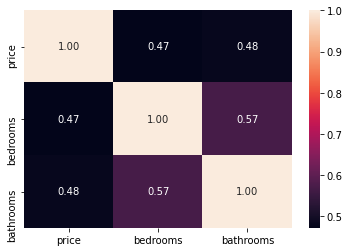

In [36]:
#Dataframe 1, Heatmap to show correlation of price to rooms
sns.heatmap(df_1.corr(), annot=True, fmt=".2f");

Text(0.5, 1.0, 'Price to # of Bedrooms Plot')

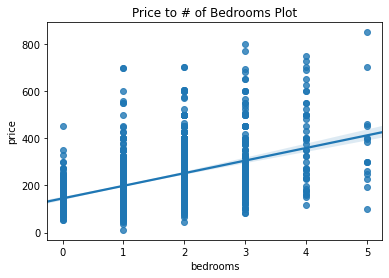

In [37]:
#Dataframe 1, plot bedrooms to pricing with seaborn 
sns.regplot(x=X['bedrooms'], y=y, truncate = False).set_title('Price to # of Bedrooms Plot')

Text(0.5, 1.0, 'Price to # of Bathrooms Plot')

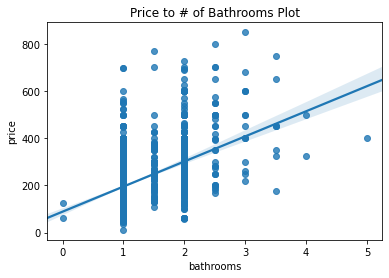

In [38]:
#Dataframe 1, plot bathrooms to pricing with seaborn (looks cleaner)
sns.regplot(x=X['bathrooms'], y=y, truncate = False).set_title('Price to # of Bathrooms Plot')

In [39]:
#Dataframe 1, descriptive stats to compliment scatterplots (# of bedrooms to pricing)
df_1_mean= df_1.groupby(df_1.bedrooms) \
.agg(
     mean_price=pd.NamedAgg(column='price', aggfunc='mean'), \
     med_price=pd.NamedAgg(column='price', aggfunc='median'), \
     cnt_listings=pd.NamedAgg(column='price', aggfunc='count'), \
     min_price=pd.NamedAgg(column='price', aggfunc='min'),  \
     max_price=pd.NamedAgg(column='price', aggfunc='max'),  \
    )
#sorted descriptive stats by mean price highest to lowest
df_1_mean.sort_values("mean_price", ascending=False)

,mean_price,med_price,cnt_listings,min_price,max_price
bedrooms,,,,,
4.0,389.400000,375.0,45,115.0,750.0
5.0,370.933333,300.0,15,100.0,849.0
3.0,305.849673,279.0,153,84.0,800.0
2.0,252.668116,247.0,690,45.0,700.0
1.0,192.869471,183.0,927,11.0,699.0
0.0,154.668990,150.0,287,55.0,450.0


In [44]:
#Dataframe 1, descriptive stats to compliment scatterplots (# of bathrooms to pricing)
df_1_mean= df_1.groupby(df_1.bathrooms) \
.agg(
     mean_price=pd.NamedAgg(column='price', aggfunc='mean'), \
     med_price=pd.NamedAgg(column='price', aggfunc='median'), \
     cnt_listings=pd.NamedAgg(column='price', aggfunc='count'), \
     min_price=pd.NamedAgg(column='price', aggfunc='min'),  \
     max_price=pd.NamedAgg(column='price', aggfunc='max'),  \
    )
#sorted descriptive stats by mean price highest to lowest
df_1_mean.sort_values("mean_price", ascending=False)

,mean_price,med_price,cnt_listings,min_price,max_price
bathrooms,,,,,
3.0,466.866667,450.0,15,219.0,849.0
3.5,450.000000,450.0,8,175.0,750.0
4.0,412.500000,412.5,2,325.0,500.0
2.5,404.729730,395.0,37,168.0,800.0
5.0,399.000000,399.0,1,399.0,399.0
2.0,289.395543,279.0,359,59.0,725.0
1.5,277.152174,255.0,92,110.0,769.0
1.0,194.269207,180.0,1601,11.0,699.0
0.0,92.500000,92.5,2,60.0,125.0


In [ ]:
#Question 1 analysis (see 6 charts and tables listed above):

#Variance high when comparing the mean list price per bedrooms and bathrooms to actual observed listings (2 plots above).
#High variance also indicated when looking at min and max prices versus mean/median prices (2 tables listed above)
#looking at the chart from Question 3 (Can we provide Airbnb owners typical rental prices in different Boston neighborhoods?)
#this variance can be explained by variation in pricing depending on  neighborhood in Boston.
#After 2.5 bathrooms variance increases (could be incorrect listings, small number of listings in categories)

In [ ]:
#Question 2 analysis:
#As the number of bedrooms increase does list price increase? What about number of bathrooms (entire units only)?

#positive relationship exists for increase in price and increase in number of bedrooms 
#scatter plots and tables above show mean and median list price increase as number of bedrooms or bathrooms increase 
 
#spotty relationship exists between increase in price and increase in bathrooms; data is inconsistent
#the confidence interval band widens after ~2.5 bathrooms (impacted by variance and size of data population)
#also, 3 bathroom units pricing > 3.5 bathroom units (small data size could be the issue)
#pricing for 1-2.5 bathrooms shows a decent relationship

In [ ]:
#Question 3 evaluation:
#Can we provide Airbnb owners typical rental prices in different Boston neighborhoods?
#See chart and table below, and analysis following graphics 

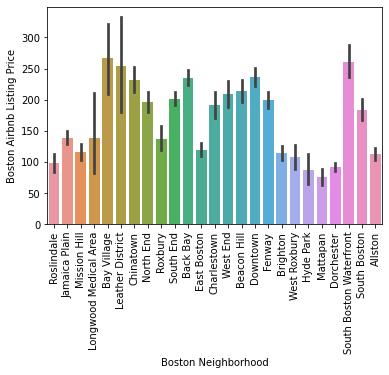

,mean_price,med_price,cnt_listings,min_price,max_price
neighbourhood_cleansed,,,,,
Bay Village,266.833333,206.5,24,90.0,500.0
South Boston Waterfront,261.148148,229.0,81,115.0,603.0
Leather District,253.600000,245.0,5,159.0,390.0
Downtown,236.459302,225.0,172,10.0,600.0
Back Bay,235.140000,209.0,300,40.0,699.0
Chinatown,232.352113,219.0,71,80.0,399.0
Beacon Hill,213.343750,195.0,192,75.0,849.0
West End,209.591837,199.0,49,60.0,450.0
South End,200.978462,180.0,325,45.0,800.0


In [47]:
#Dataframe 3, price per Boston neighborhood, seaborn barplot, unsorted
sns.barplot(x = 'neighbourhood_cleansed', y = 'price', data = df_3)
plt.ylabel('Boston Airbnb Listing Price')
plt.xlabel('Boston Neighborhood')
plt.xticks(rotation=90)
plt.show()

#descriptive stats
df_3_mean= df_3.groupby(df_3.neighbourhood_cleansed) \
.agg(
     mean_price=pd.NamedAgg(column='price', aggfunc='mean'), \
     med_price=pd.NamedAgg(column='price', aggfunc='median'), \
     cnt_listings=pd.NamedAgg(column='price', aggfunc='count'), \
     min_price=pd.NamedAgg(column='price', aggfunc='min'),  \
     max_price=pd.NamedAgg(column='price', aggfunc='max'),  \
    )
#sorted descriptive stats by mean price highest to lowest
df_3_mean.sort_values("mean_price", ascending=False)

In [80]:
#Question 3 analysis:
#table above lists price by Boston neighborhood highest to lowest. Chart does as well, just not in order (could not find a good
#method for this)
#we previously removed outliers (records with prices below 5th and above 95th percentiles) providing a more reliable mean

#some outliers remain; should be careful when drawing conclusions (small population size in some neighborhoods, etc):
#Example1 Downtown (table) still has a min price of $10 (could be driving the average lower; could be an error in the listing)
#Example2 Leather district has 5 listings (table, but min listing still relatively high (may not be an issue) 
#Conclusion: after removing outliers (< 5th percentile, > 95th percentile) mean should be good to show rental prices high>low
df_3

,price,neighbourhood_cleansed
0,250.0,Roslindale
1,65.0,Roslindale
2,65.0,Roslindale
3,75.0,Roslindale
4,79.0,Roslindale
...,...,...
3580,69.0,Charlestown
3581,150.0,Allston
3582,198.0,Charlestown
3583,65.0,Charlestown


In [ ]:
#Question 4 evaluation:
#Can we provide Boston Airbnb owners feedback on rental type demand (IE, are rooms/shared rooms/full units in higher demand)?

#See table and analysis below

In [81]:
#dataframe 4 statistics
df_4_mean= df_4.groupby(df_4.room_type) \
.agg(
    mean_avail_90days=pd.NamedAgg(column='availability_90', aggfunc='mean'), \
     med_avail_90days=pd.NamedAgg(column='availability_90', aggfunc='median'), \
     cnt_rentals=pd.NamedAgg(column='availability_90', aggfunc='count'), \
     min_avail_90days=pd.NamedAgg(column='availability_90', aggfunc='min'),  \
     max_avail_90days=pd.NamedAgg(column='availability_90', aggfunc='max'),  \
     std_dev=pd.NamedAgg(column='availability_90', aggfunc='std'),
    )
#sorted by median price highest to lowest (may be a better indicator of category (high to low) than mean)
df_4_mean.sort_values("mean_avail_90days", ascending=False)

,mean_avail_90days,med_avail_90days,cnt_rentals,min_avail_90days,max_avail_90days,std_dev
room_type,,,,,,
Shared room,48.328767,57,73,0,90,35.878675
Entire home/apt,41.000500,41,2001,0,90,32.616323
Private room,39.404819,38,1245,0,90,32.001557


In [ ]:
#Question 4 analysis:
#private rooms have the least days available in a 90 day period (lower median/mean availability)
# Followed by Entire home/apt, followed by shared room (least demand)
# Entire homes/apt's and Private rooms have a healthy population size; shared rooms do not (may not be as reliable)
#private rooms standard deviation the lowest of three types (most reliable); least reliable stdev = shared rooms
#CONCLUSION: private rooms are the most in demand room types for Airbnb listings in Boston
#shared rooms are least in demand for Airbnb listings in Boston